Breakpoints (x) at segment boundaries (excluding final endpoint):
[]

   segment  start_idx  end_idx  start_x       end_x     slope    intercept  \
0        1          0     2362   167.31  9236903.64  0.000603  1806.932082   

   n_points           RSS        R2  
0      2362  4.222580e+08  0.937172  


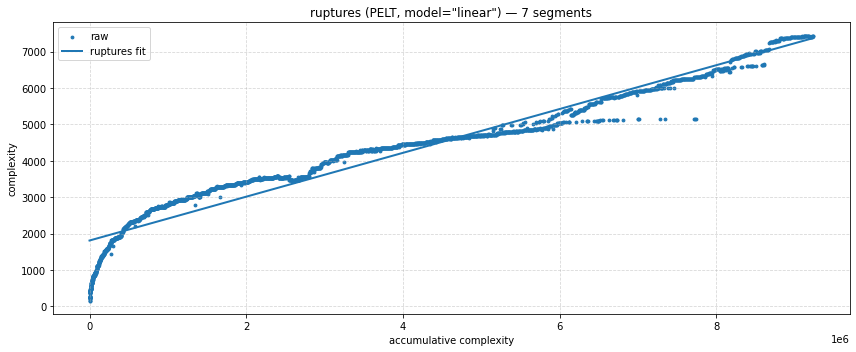


Segment summary saved to: ruptures_segments_summary.csv


In [6]:
# If needed:
# pip install ruptures

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ruptures as rpt

# =======================
# Parameters (edit these)
# =======================
csv_path = "complexity_and_accumulation_for_composer_7segments_RMSE.csv"
x_col = "accumulative_raw"
y_col = "complexity_raw"
n_segments = 7                      # -> will find n_segments - 1 breakpoints
save_csv_path = "ruptures_segments_summary.csv"  # set to None to skip saving

# =======================
# Load & prepare data
# =======================
df = pd.read_csv(csv_path)
x = df[x_col].to_numpy(dtype=float)
y = df[y_col].to_numpy(dtype=float)

# Ensure sorted by x
order = np.argsort(x)
x, y = x[order], y[order]

# =======================
# Detect breakpoints (PELT)
# =======================
signal = y.reshape(-1, 1)
n_bkps = n_segments - 1

algo = rpt.Pelt(model="linear").fit(signal)
bkps_idx = algo.predict(n_bkps)  # positional arg; returns segment end indices incl. len(signal)

# Convert indices to segments: [start, end)
starts = [0] + bkps_idx[:-1]
ends   = bkps_idx
segments_idx = list(zip(starts, ends))

# =======================
# Fit line & compute stats per segment
# =======================
rows = []
fits = []  # (xs, ys) for plotting
for i, (i0, i1) in enumerate(segments_idx, start=1):
    Xi = x[i0:i1]
    Yi = y[i0:i1]
    n = len(Xi)
    if n < 2:
        continue

    # least squares line: y = a + b x
    X1 = np.vstack([np.ones_like(Xi), Xi]).T
    a, b = np.linalg.lstsq(X1, Yi, rcond=None)[0]
    yhat = a + b*Xi
    rss = float(np.sum((Yi - yhat)**2))
    tss = float(np.sum((Yi - Yi.mean())**2))
    r2 = 1.0 - (rss / tss if tss > 0 else np.nan)

    rows.append({
        "segment": i,
        "start_idx": i0,
        "end_idx": i1,
        "start_x": float(Xi.min()),
        "end_x": float(Xi.max()),
        "slope": float(b),
        "intercept": float(a),
        "n_points": int(n),
        "RSS": rss,
        "R2": r2,
    })

    # smooth line for plotting
    xs = np.linspace(Xi.min(), Xi.max(), 200)
    ys = a + b*xs
    fits.append((xs, ys))

summary = pd.DataFrame(rows)
print("Breakpoints (x) at segment boundaries (excluding final endpoint):")
print([float(x[idx-1]) for idx in bkps_idx[:-1]])
print()
print(summary)

# =======================
# Plot
# =======================
plt.figure(figsize=(12, 5))
plt.scatter(x, y, s=8, label="raw")

# piecewise linear fits
for j, (xs, ys) in enumerate(fits):
    plt.plot(xs, ys, linewidth=2, label="ruptures fit" if j == 0 else None)

# vertical lines at breaks (skip last terminal index)
for idx in bkps_idx[:-1]:
    plt.axvline(x[idx], linestyle="--", alpha=0.3)

plt.title(f'ruptures (PELT, model="linear") — {n_segments} segments')
plt.xlabel("accumulative complexity")
plt.ylabel("complexity")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# =======================
# Save (optional)
# =======================
if save_csv_path:
    summary.to_csv(save_csv_path, index=False)
    print(f"\nSegment summary saved to: {save_csv_path}")
